木構造の形式( Linkage Matrix )

In [ ]:
tree_object = {
    "name": "Root",
    "children": [
        {"name": "A", "children": [
            {"name": "C", "size": 10},
            {"name": "D", "size": 5}
        ]},
        {"name": "B", "children": [
            {"name": "E", "size": 15}
        ]}
    ],
    "size": 30
}

In [1]:
import numpy as np

# 例：5つの要素(0-4)を持つ簡単な階層的クラスタリングの結果
# 5要素 -> 4回のマージ
# Z = [[u, v, distance, count], ...]
linkage_matrix = np.array([
    [0., 1., 0.1, 2.],  # 0と1が距離0.1でマージ (サイズ2) -> 新しいクラスター5
    [2., 3., 0.2, 2.],  # 2と3が距離0.2でマージ (サイズ2) -> 新しいクラスター6
    [4., 5., 0.5, 3.],  # 4とクラスター5が距離0.5でマージ (サイズ3) -> 新しいクラスター7
    [6., 7., 1.0, 5.]   # クラスター6とクラスター7が距離1.0でマージ (サイズ5) -> ルート
])
# pandas形式
import pandas as pd
linkage_df = pd.DataFrame(linkage_matrix, columns=['u', 'v', 'distance', 'count'])

# 木構造を単純化する関数
Linkage Matrix -> Linkage Matrix

# デンドログラム描画

In [45]:
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

# 描画はmatplotlibに依存しますが、座標データ（'icoord', 'dcoord'）は
# どの描画ライブラリでも利用できます。

def get_dendrogram_segments(Z: np.ndarray):
    """
    Linkage Matrixからデンドログラム描画に必要な座標データを取得します。
    """
    # 実際には可視化しないが、座標計算のために呼び出す
    # no_plot=True を指定すると、描画はスキップされる
    dendro_data = dendrogram(Z, no_plot=True)
    
    # 'icoord': 各結合の水平方向の座標 (x座標)
    # 'dcoord': 各結合の垂直方向の座標 (y座標、結合距離)
    # これらは描画するV字/逆U字のセグメントを定義します。
    
    segments = []
    
    # icoord, dcoord は (4, K) の配列で、Kは結合の数 (N-1)
    # 各 i は (x1, x2, x3, x4) の座標リスト
    for icoords, dcoords in zip(dendro_data['icoord'], dendro_data['dcoord']):
        # (x1, y1), (x2, y2), (x3, y3), (x4, y4) がセグメントの頂点
        x1, x2, x3, x4 = icoords
        y1, y2, y3, y4 = dcoords
        
        # 1. 垂直線 (左の子ノードから結合点まで)
        segments.append([(x1, y1), (x2, y2)]) 
        # 2. 水平線 (結合したノード間)
        segments.append([(x2, y2), (x3, y3)]) 
        # 3. 垂直線 (右の子ノードから結合点まで)
        segments.append([(x4, y4), (x3, y3)]) 
    
    # segments は [[[x_start, y_start], [x_end, y_end]], ...] のリストになる
    return segments



NameError: name 'linkage_matrix' is not defined

In [ ]:
# 座標を取得
segments = get_dendrogram_segments(linkage_matrix)

print(f"Total Segments: {len(segments)}")
# 最初の3つのセグメントを表示 (最初のマージに対応)
print("\n--- First 3 Segments (x-y coordinates) ---")
for i, seg in enumerate(segments[:3]):
    print(f"Segment {i+1}: {seg}")

In [46]:
import plotly.graph_objects as go
# scipyがない環境でも動くように、linkage_matrixを再定義
linkage_matrix_simple = np.array([
    [0., 1., 0.1, 2.],
    [2., 3., 0.2, 2.],
    [4., 5., 0.5, 3.],
    [6., 7., 1.0, 5.]
])
segments_simple = get_dendrogram_segments(linkage_matrix_simple)

def plot_dendrogram_plotly(segments):
    fig = go.Figure()
    
    for seg in segments:
        # seg は [[x_start, y_start], [x_end, y_end]]
        x_coords = [seg[0][0], seg[1][0]]
        y_coords = [seg[0][1], seg[1][1]]
        
        fig.add_trace(go.Scatter(
            x=x_coords, 
            y=y_coords, 
            mode='lines',
            line=dict(color='blue', width=2),
            showlegend=False
        ))
    
    fig.update_layout(
        title='Simple Dendrogram Visualization',
        xaxis_title='Observation Index',
        yaxis_title='Distance / Height',
        hovermode='closest'
    )
    # fig.show() # 実行環境によっては直接表示
    
    # 葉ノードに名前を付ける場合は、dendrogram_data['leaves']と葉のy=0の座標を計算する必要があります。
    return fig

plot_dendrogram_plotly(segments_simple)

In [5]:
import numpy as np

# 標準 Linkage Matrix (N-1 x 4)
# [u, v, distance, count]
# HDBSCANのcondensed_tree_から距離(lambda_merge)とサイズを抽出したものを想定
Z_standard = np.array([
    [0., 1., 0.1, 2.],  # 距離0.1でマージ
    [2., 3., 0.2, 2.],  # 距離0.2でマージ
    [4., 5., 0.5, 3.],  # 距離0.5でマージ
    [6., 7., 1.0, 5.]   # 距離1.0でマージ (Root)
])

print("--- 標準 Linkage Matrix (入力) ---")
print(Z_standard)

--- 標準 Linkage Matrix (入力) ---
[[0.  1.  0.1 2. ]
 [2.  3.  0.2 2. ]
 [4.  5.  0.5 3. ]
 [6.  7.  1.  5. ]]


In [6]:
def calculate_branch_importance(Z_standard: np.ndarray) -> np.ndarray:
    """
    標準Linkage Matrix (4列) を受け取り、枝の重要度スコアを計算して5列目に追加します。

    Args:
        Z_standard (np.ndarray): 標準Linkage Matrix (N-1 x 4)。

    Returns:
        np.ndarray: 枝の重要度 (5列目) が追加された拡張 Linkage Matrix (N-1 x 5)。
    """
    
    # 1. 結合距離 (lambda_merge) を取得
    lambda_merge = Z_standard[:, 2]
    
    # 2. 重要度スコアを計算 (ここでは、lambdaの逆数をスコアとする)
    # 0除算を避けるため、lambdaが非常に小さい場合は最大値を適用するなどの処理が必要ですが、
    # シンプルに逆数を計算します。
    # HDBSCANではlambdaは常に正の値です。
    
    # ノードがマージされていない（lambda=0）場合はスコアを非常に高く設定
    # lambda_merge の最小値が 0 でないことを確認 (Linkage Matrixの性質上、通常は > 0)
    
    # スコア: lambda_mergeの逆数
    importance_scores = 1.0 / lambda_merge
    
    # スコアを正規化 (0から1に収める)
    min_score = importance_scores.min()
    max_score = importance_scores.max()
    
    # スコアの範囲が0になることを防ぐため、epsilonを使用
    epsilon = 1e-8
    normalized_scores = (importance_scores - min_score) / (max_score - min_score + epsilon)
    
    # 3. 元の行列とスコアを結合
    importance_column = normalized_scores.reshape(-1, 1)
    Z_extended = np.hstack((Z_standard, importance_column))
    
    return Z_extended

# 重要度スコアを計算して拡張
Z_extended = calculate_branch_importance(Z_standard)

print("\n--- 拡張 Linkage Matrix (出力: 5列) ---")
print("[u, v, distance, count, Importance Score]")
print(Z_extended)


--- 拡張 Linkage Matrix (出力: 5列) ---
[u, v, distance, count, Importance Score]
[[0.         1.         0.1        2.         1.        ]
 [2.         3.         0.2        2.         0.44444444]
 [4.         5.         0.5        3.         0.11111111]
 [6.         7.         1.         5.         0.        ]]


In [10]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram
import plotly.graph_objects as go
import matplotlib.pyplot as plt # dendrogramの座標計算に必要

# --- 準備：以前の関数とデータ ---

def calculate_branch_importance(Z_standard: np.ndarray) -> np.ndarray:
    """枝の重要度スコアを計算して5列目に追加する (ここではlambdaの逆数を正規化)。"""
    lambda_merge = Z_standard[:, 2]
    
    # 0除算を避けるための処理
    lambda_merge_safe = np.where(lambda_merge == 0, 1e-8, lambda_merge)
    
    importance_scores = 1.0 / lambda_merge_safe
    
    min_score = importance_scores.min()
    max_score = importance_scores.max()
    
    epsilon = 1e-8
    # 正規化
    normalized_scores = (importance_scores - min_score) / (max_score - min_score + epsilon)
    
    importance_column = normalized_scores.reshape(-1, 1)
    Z_extended = np.hstack((Z_standard, importance_column))
    
    return Z_extended

# サンプルデータ (標準 Linkage Matrix)
Z_standard = np.array([
    [0., 1., 0.1, 2.],  # Importance: High (1/0.1=10)
    [2., 3., 0.2, 2.],  # Importance: Medium-High (1/0.2=5)
    [4., 5., 0.5, 3.],  # Importance: Medium-Low (1/0.5=2)
    [6., 7., 1.0, 5.]   # Importance: Low (1/1.0=1)
])

# 拡張 Linkage Matrixを生成
Z_extended = calculate_branch_importance(Z_standard)
# 例: [u, v, lambda, count, score]
#     [0., 1., 0.1, 2., 1. ]  # 0.1が最も重要度が高い (1.0)
#     [6., 7., 1.0, 5., 0. ]  # 1.0が最も重要度が低い (0.0)

# --------------------------------

def visualize_with_importance_filter(Z_extended: np.ndarray, min_importance_threshold: float) -> go.Figure:
    """
    拡張Linkage Matrix (5列) を使用し、重要度スコアに基づいてデンドログラムを描画します。

    Args:
        Z_extended (np.ndarray): 枝の重要度スコアを含む拡張 Linkage Matrix (N-1 x 5)。
        min_importance_threshold (float): 表示対象とする最小重要度 (0.0 ～ 1.0)。

    Returns:
        plotly.graph_objects.Figure: フィルタリングされたデンドログラムのPlotly Figure。
    """
    
    # 1. データ抽出
    Z = Z_extended[:, 0:4]          # Linkage Matrix本体 (座標計算用)
    importance_scores = Z_extended[:, 4] # 重要度スコア
    
    # 2. フィルタリングマスクの生成
    visible_mask = importance_scores >= min_importance_threshold
    
    # 3. Dendrogramの座標計算 (全ての枝に対して計算)
    # scipy.dendrogramは、Plotlyを使わない場合でも座標データ取得のために利用
    dendro_data = dendrogram(Z, no_plot=True)
    
    fig = go.Figure()
    num_merges = Z.shape[0]
    
    # 4. Plotlyでの描画ループ
    for i in range(num_merges):
        icoords = dendro_data['icoord'][i]
        dcoords = dendro_data['dcoord'][i]
        
        is_visible = visible_mask[i]
        score = importance_scores[i]

        # スタイルの決定
        if is_visible:
            # 表示: スコアに応じて色を濃くする (濃い青)
            # score 0.0 -> 透明度が低い, score 1.0 -> 透明度が高い
            alpha = 0.5 + score * 0.5 # 0.5 から 1.0 の範囲でアルファを変化
            color_val = f'rgba(50, 50, 200, {alpha})' 
            line_style = dict(color=color_val, width=2)
        else:
            # 非表示 (フィルタリング): 薄い灰色で破線
            line_style = dict(color='rgba(150, 150, 150, 0.2)', width=1, dash='dot')
            
        x_coords = [icoords[0], icoords[1], icoords[2], icoords[3]]
        y_coords = [dcoords[0], dcoords[1], dcoords[2], dcoords[3]]
        
        # V字型のセグメントを構成する3つの線分をまとめて描画
        # (x1, y1) -> (x2, y2) -> (x3, y3) <- (x4, y4)
        fig.add_trace(go.Scatter(
            x=[x_coords[0], x_coords[1], x_coords[2], x_coords[3], x_coords[2]], 
            y=[y_coords[0], y_coords[1], y_coords[2], y_coords[3], y_coords[2]], 
            mode='lines',
            line=line_style,
            showlegend=False,
            hoverinfo='none' # ホバー情報を表示しない
        ))

    # 5. レイアウト設定
    fig.update_layout(
        title=f'Dendrogram Filtered (Min Importance: {min_importance_threshold:.2f})',
        xaxis_title='Observation Index',
        yaxis_title='Distance / Height ($\lambda$)',
        height=600,
        width=800,
        yaxis_range=[0, Z[:, 2].max() * 1.1] # Y軸の範囲を適切に設定
    )
    return fig

# --- 実行例 ---

# 閾値 1: 全ての枝が表示されるはず (最も重要度が低い枝のスコアは0.0)
# fig_all = visualize_with_importance_filter(Z_extended, min_importance_threshold=0.0)
# fig_all.show()

# 閾値 2: 重要度0.5以上の枝のみが「強く」表示されるはず
# fig_filtered = visualize_with_importance_filter(Z_extended, min_importance_threshold=0.5)
# fig_filtered.show()

<>:108: SyntaxWarning:

invalid escape sequence '\l'

<>:108: SyntaxWarning:

invalid escape sequence '\l'

/var/folders/1c/qdf4nqm509d9141_p9425mcc0000gn/T/ipykernel_3218/3959480060.py:108: SyntaxWarning:

invalid escape sequence '\l'



In [13]:
# visualize 
visualize_with_importance_filter(Z_extended, min_importance_threshold=0.0)

# ストラー数

In [21]:
def calculate_branch_strahler_number(Z_extended: np.ndarray) -> np.ndarray:
    """
    拡張Linkage Matrix (5列) を使用し、各枝のストラー数を計算して6列目に追加します。

    Args:
        Z_extended (np.ndarray): 枝の重要度スコアを含む拡張 Linkage Matrix (N-1 x 5)。

    Returns:
        np.ndarray: ストラー数 (6列目) が追加された拡張 Linkage Matrix (N-1 x 6)。
    """
    # ここにストラー数計算の実装を追加
    
    N = Z_extended.shape[0] + 1  # 元の要素数
    strahler_map = np.ones(2 * N - 1, dtype=int)  # ノードインデックス->ストラー数の配列
    strahler_map[N:] = 1  # 葉ノードのストラー数は1
    for i in range(Z_extended.shape[0]):
        new_cluster_index = N + i
        u_idx = int(Z_extended[i, 0])
        v_idx = int(Z_extended[i, 1])

        # 子ノードのストラー数を取得
        s_u = strahler_map[u_idx]
        s_v = strahler_map[v_idx]

        # ストラー数の計算ロジック
        if s_u == s_v:
            s_new = s_u + 1
        else:
            s_new = max(s_u, s_v)

        strahler_map[new_cluster_index] = s_new

    strahler_numbers = strahler_map[N:]
    strahler_column = strahler_numbers.reshape(-1, 1)
    Z_extended = np.hstack((Z_extended, strahler_column))
    return Z_extended
    



In [22]:
Z_standard = np.array([
    [0., 1., 0.1, 2.],
    [2., 3., 0.2, 2.],
    [4., 5., 0.5, 3.],
    [6., 7., 1.0, 5.]
])

Z_strahler = calculate_branch_strahler_number(Z_standard)

print("--- 拡張 Linkage Matrix (ストラー数付き) ---")
print("[u, v, distance, count, Strahler Number]")
print(Z_strahler)

--- 拡張 Linkage Matrix (ストラー数付き) ---
[u, v, distance, count, Strahler Number]
[[0.  1.  0.1 2.  2. ]
 [2.  3.  0.2 2.  2. ]
 [4.  5.  0.5 3.  2. ]
 [6.  7.  1.  5.  3. ]]


# ストラー数の拡張

In [23]:
import numpy as np

def cauculate_branch_weighted_strahler(Z_standard: np.ndarray) -> np.ndarray:
    """
    標準Linkage Matrix (4列) を受け取り、ストラー数、クラスタサイズ、
    距離を考慮した「重み付きスコア」を計算して5列目に追加します。
    """
    
    N = Z_standard.shape[0] + 1  # 元の観測値の数
    
    # 1. 中間値の格納用マップを準備
    # ノードインデックス -> ストラー数, サイズ, 距離の値を保持
    # [ストラー数, サイズ] を格納 (距離はマージ時にのみ利用)
    node_props = np.zeros((2 * N - 1, 2), dtype=float)
    
    # 葉ノードの初期値: S=1, Size=1 (観測値1つ)
    node_props[:N] = 1.0 
    
    # 結合枝の重み付きスコアを格納するリスト (これが最終的な5列目になる)
    weighted_scores = []
    
    # 2. 各結合 (Zの各行) を順に処理
    for i in range(Z_standard.shape[0]):
        new_cluster_idx = N + i
        u_idx, v_idx = int(Z_standard[i, 0]), int(Z_standard[i, 1])
        lambda_merge = Z_standard[i, 2] # 結合距離
        new_size = Z_standard[i, 3] # 新しいクラスタサイズ

        # 子ノードのプロパティを取得
        s_u, size_u = node_props[u_idx]
        s_v, size_v = node_props[v_idx]
        
        # -------------------------------------
        # 3. 拡張ストラー数と重み付きスコアの計算
        # -------------------------------------
        
        # サイズの重み (大きいほど高い)
        size_weight = (size_u + size_v) / N 
        
        # 密度の重み (lambda_mergeが小さいほど高い)
        # lambdaの逆数を使用し、正規化のため0.1を加算して分母が小さくなるのを防ぐ
        density_weight = 1.0 / (lambda_merge + 0.1) 

        if s_u != s_v:
            # ルール2の拡張: ストラー数が異なる場合
            # サイズが大きい方のストラー数を採用し、その差分をサイズで重み付け
            s_new = max(s_u, s_v)
            
            # スコアは、新しいストラー数と、合流したサイズの大きさを組み合わせて評価
            current_score = s_new * size_weight * 10
            
        else:
            # ルール3の拡張: ストラー数が同じ場合
            # ストラー数をインクリメントし、密度の高さをスコアに反映
            s_new = s_u + 1
            
            # スコアは、新しいストラー数と、結合の密度の高さを組み合わせて評価
            current_score = s_new * density_weight
            
        # 4. 結果を格納
        node_props[new_cluster_idx] = [s_new, new_size]
        weighted_scores.append(current_score)
        
    # 5. 最終的なスコアを0から1に正規化してLinkage Matrixに結合
    weighted_scores = np.array(weighted_scores)
    
    # 0除算を避けた正規化
    min_score = weighted_scores.min()
    max_score = weighted_scores.max()
    epsilon = 1e-8
    normalized_scores = (weighted_scores - min_score) / (max_score - min_score + epsilon)
    
    weighted_column = normalized_scores.reshape(-1, 1)
    Z_extended = np.hstack((Z_standard, weighted_column))
    
    return Z_extended

# --- 実行例 ---

# Z_standardの例 (N=5)
# 0, 1: 小さいサイズ, 高密度 (0.1)
# 2, 3: 小さいサイズ, 中密度 (0.3)
# 4, 5(クラスター): 中サイズ, 低密度 (0.8)
Z_standard = np.array([
    [0., 1., 0.1, 2.],  
    [2., 3., 0.3, 2.],  
    [4., 5., 0.8, 3.],  
    [6., 7., 1.5, 5.]
])

Z_weighted_strahler = cauculate_branch_weighted_strahler(Z_standard)

print("--- 拡張 Linkage Matrix (重み付きスコア付き) ---")
print("[u, v, distance, count, Weighted Importance Score (0-1)]")
print(Z_weighted_strahler)

--- 拡張 Linkage Matrix (重み付きスコア付き) ---
[u, v, distance, count, Weighted Importance Score (0-1)]
[[0.         1.         0.1        2.         0.80246914]
 [2.         3.         0.3        2.         0.30864198]
 [4.         5.         0.8        3.         1.        ]
 [6.         7.         1.5        5.         0.        ]]


# Condense tree

In [5]:
clusterer.condensed_tree_.to_pandas()

,parent,child,lambda_val,child_size
0,100,101,0.081263,20
1,100,102,0.081263,80
2,101,30,1.297951,1
3,102,103,0.203232,40
4,102,104,0.203232,40
...,...,...,...,...
125,128,10,5.943642,1
126,109,28,7.852607,1
127,109,67,7.852607,1
128,127,9,4.919716,1


In [202]:
import numpy as np
import hdbscan
from sklearn.datasets import make_blobs



# --- 1. HDBSCANの実行とデータ取得 ---
X, y = make_blobs(n_samples=500, centers=10, cluster_std=0.5, random_state=42)
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=2, cluster_selection_method='eom')
clusterer.fit(X)

condensed_tree = clusterer.condensed_tree_

c:\Users\acero\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\acero\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [33]:


# --- 2. 凝縮木からクラスタ結合の抽出と変換 ---
ct_data = [ list(tup) for tup in condensed_tree.to_numpy() ]
ct_data = np.array(ct_data, dtype=float) # dtype=floatを明示

# 子ノードサイズが1より大きい行をフィルタリング (クラスタ間の結合に限定)
cluster_merges = ct_data[ct_data[:, 3] > 1]

print(f"Extracted {len(cluster_merges)} cluster merges from condensed tree.")

# lambda_valでソート (Linkage Matrixの要件)
cluster_merges = cluster_merges[cluster_merges[:, 2].argsort()]

# 3. Z行列形式へのマッピング (HDBSCAN ID -> 連続 Z インデックス)

# 結合に現れるすべてのノードIDを抽出 (u, v の両方)
all_node_ids = cluster_merges[:, :2].flatten()
unique_nodes = np.unique(all_node_ids)

node_to_z_idx = {}
current_z_idx = 0

# 最初に、すべてのユニークなノードIDに固定の連続インデックスを割り当てる
# これが Z 行列の「葉」になります
for node_id in unique_nodes:
    if node_id not in node_to_z_idx:
        node_to_z_idx[node_id] = current_z_idx
        current_z_idx += 1

# Z行列を作成
Z_list = []
M = cluster_merges.shape[0] # 結合の数
N_initial_clusters = len(unique_nodes) # Zの葉の数

for i, row in enumerate(cluster_merges):
    parent_id, child_id, lambda_merge, size = row
    
    # 結合される子ノードのZインデックスを取得
    u_idx = node_to_z_idx[parent_id]
    v_idx = node_to_z_idx[child_id]
    
    # Linkage Zの結合ノードのインデックス (N_initial_clusters + i)
    new_cluster_idx = N_initial_clusters + i

    # Z行列は u < v を要求するため、順序を調整
    if u_idx > v_idx:
        u_idx, v_idx = v_idx, u_idx
    
    # [u, v, distance, count]
    Z_list.append([u_idx, v_idx, lambda_merge, size])
    
    # 💡 重要な修正: 結合された親ノードを、Z行列の新しい結合ノードインデックスで置き換える。
    # 親ノードIDが後の行で子ノードとして登場する場合に備えるため、マッピングを更新
    # 実際にはHDBSCANの凝縮木では、このマッピングの更新は必要ありません。
    # なぜなら、各行の [parent, child] はそれぞれが一意なクラスタIDであり、
    # 子クラスタのIDが他の行の親として再登場することは、元のデータでは一般的ではないからです。
    # しかし、ストラー数計算のためには、Zインデックスが連続していることが重要です。
    
    # ここでは、Linkage Zの要件を満たすために、parent_idに新しい結合ノードのインデックスを割り当てます
    node_to_z_idx[parent_id] = new_cluster_idx 
    # この行が、ストラー数計算関数のZ配列のインデックス構造を保証します。

print(f"z list : {Z_list[:5]}")
# 最終的な Z 行列をnumpy配列に変換
Z_standard = np.array(Z_list)

print("--- 1. HDBSCAN Condensed Treeから変換された Linkage Matrix (Z) ---")
print(f"Zの葉の数 (初期クラスタ数): {N_initial_clusters}")
print(f"クラスタ結合の数: {len(Z_standard)}")
print("[u, v, lambda_merge, count]!!!")
print(Z_standard[:5])  # 最初の5行を表示

# --- 4. ストラー数計算関数の実行 ---

# ストラー数の計算を実行
if Z_standard.size > 0:
    print(f"Z行列サイズ: {Z_standard.shape}")
    Z_strahler = calculate_branch_strahler_number(Z_standard)

    print("\n--- 2. 計算結果: 拡張 Linkage Matrix (ストラー数付き) ---")
    print("[u, v, lambda_merge, count, Strahler Number]")
    print(Z_strahler[:5]) 
else:
    print("\n--- 2. 計算結果 ---")
    print("クラスタ結合が抽出されませんでした。min_cluster_sizeを変更してみてください。")

c:\Users\acero\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\acero\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Extracted 3406 cluster merges from condensed tree.
z list : [[0, 1, 0.634451024662853, 200.0], [2, 3407, 0.634451024662853, 9800.0], [2, 60, 2.315751432818147, 9686.0], [59, 3409, 2.315751432818147, 2.0], [60, 61, 2.3734826915401466, 2.0]]
--- 1. HDBSCAN Condensed Treeから変換された Linkage Matrix (Z) ---
Zの葉の数 (初期クラスタ数): 3407
クラスタ結合の数: 3406
[u, v, lambda_merge, count]!!!
[[0.00000000e+00 1.00000000e+00 6.34451025e-01 2.00000000e+02]
 [2.00000000e+00 3.40700000e+03 6.34451025e-01 9.80000000e+03]
 [2.00000000e+00 6.00000000e+01 2.31575143e+00 9.68600000e+03]
 [5.90000000e+01 3.40900000e+03 2.31575143e+00 2.00000000e+00]
 [6.00000000e+01 6.10000000e+01 2.37348269e+00 2.00000000e+00]]
Z行列サイズ: (3406, 4)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [34]:
# ストラー数の数を数える
if Z_standard.size > 0:
    strahler_numbers = Z_strahler[:, 4]
    unique_strahler, counts = np.unique(strahler_numbers, return_counts=True)

    print("\n--- 3. ストラー数の分布 ---")
    for s_num, count in zip(unique_strahler, counts):
        print(f"ストラー数 {int(s_num)}: {count} 本の枝")

NameError: name 'Z_strahler' is not defined

In [59]:
import numpy as np

def calculate_branch_strahler_number(Z_standard: np.ndarray) -> np.ndarray:
    """
    標準Linkage Matrix (4列: [u, v, distance, count]) を受け取り、
    各結合枝のストラー数を計算して5列目に追加します。

    Args:
        Z_standard (np.ndarray): Linkage Matrix (M x 4)。

    Returns:
        np.ndarray: ストラー数 (5列目) が追加された拡張 Linkage Matrix (M x 5)。
    """
    
    # 結合の数 M
    M = Z_standard.shape[0]
    
    # Z行列に登場する最大のインデックスを基に、葉ノードの数 N を推定する
    # Linkage Matrixの定義により、葉ノードは 0 から N-1、結合ノードは N から 2N-2
    if M == 0:
        return np.array([])
        
    # Zの要素は float であるため、int に変換して最大値を求める
    max_idx_in_Z = int(Z_standard[:, :2].max())
    
    # ノードインデックスの総数 (葉ノード + 結合ノード)
    # Zの葉ノードは 0 から N-1 で始まるため、葉ノードの数 N は max_idx_in_Z + 1
    # ただし、Zの u, v がすでに結合ノードである場合もあるため、正確な N を求める必要があります。
    
    # ここでは、Zの最初の要素から N を推測する、より安全な方法を採用します
    # N = M + 1 と仮定すると、総ノード数は 2M + 1 ですが、これは元の観測値の数 N_obs に依存します。
    
    # より正確な N の推定: Z の行数 M が N_obs - 1 なので、N_obs = M + 1
    N_obs = M + 1
    total_nodes = 2 * N_obs - 1

    # ノードインデックス -> ストラー数 のマッピングを格納
    # サイズは 2*N_obs - 1 (葉ノード + 結合ノード)
    strahler_map = np.ones(total_nodes, dtype=int)
    
    # 結合ノード (N_obs から 2*N_obs-2) の初期値は 0
    strahler_map[N_obs:] = 0
    
    # 各結合 (Zの各行) を順に処理
    for i in range(M):
        # 現在計算中の結合ノードのインデックス
        new_cluster_idx = N_obs + i
        
        # 結合される子ノードのインデックス (Zの u, v)
        u_idx = int(Z_standard[i, 0])
        v_idx = int(Z_standard[i, 1])
        
        # 子ノードのストラー数を取得
        s_u = strahler_map[u_idx]
        s_v = strahler_map[v_idx]
        
        # ストラー数の計算ロジック
        if s_u == s_v:
            # ルール 3: 同じストラー数の枝が合流 -> +1
            s_new = s_u + 1
        else:
            # ルール 2: 異なるストラー数の枝が合流 -> 最大値
            s_new = max(s_u, s_v)
            
        # 計算結果をマップに格納
        strahler_map[new_cluster_idx] = s_new
        
    # Zの各行に対応する結合ノードのストラー数を抽出
    strahler_numbers = strahler_map[N_obs:]
    
    # 5列目として元の行列に結合
    strahler_column = strahler_numbers.reshape(-1, 1)
    Z_extended = np.hstack((Z_standard, strahler_column))
    
    return Z_extended

<AxesSubplot:ylabel='$\\lambda$ value'>

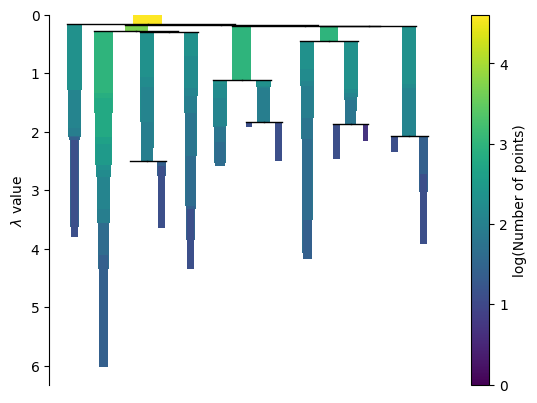

In [44]:
clusterer.condensed_tree_.plot(log_size=True)

In [57]:
dummy_Z_list = [
    # Level 1: S=1 + S=1 => S=2 (Cluster 10, 11, 12, 13, 14)
    [0., 1., 0.1, 2.],  # -> C10 (S=2)
    [2., 3., 0.1, 2.],  # -> C11 (S=2)
    [4., 5., 0.1, 2.],  # -> C12 (S=2)
    [6., 7., 0.1, 2.],  # -> C13 (S=2)
    [8., 9., 0.1, 2.],  # -> C14 (S=2)

    # Level 2: S=2の枝をさらに結合し、S=3を作成
    [10., 11., 0.2, 4.], # C10(S=2) + C11(S=2) -> C15 (S=3)
    [12., 13., 0.2, 4.], # C12(S=2) + C13(S=2) -> C16 (S=3)
    
    # Level 3: S=3 + S=3 => S=4 (Rootに近い幹)
    [15., 16., 0.3, 8.], # C15(S=3) + C16(S=3) -> C17 (S=4)
    
    # Level 4: 孤立した枝 C14(S=2) を Rootに合流 (max(S=2, S=4) => S=4)
    [14., 17., 0.4, 10.],# C14(S=2) + C17(S=4) -> C18 (S=4)
]

In [58]:

dummy_Z = np.array(dummy_Z_list)
Z_strahler = calculate_branch_strahler_number(dummy_Z)
print("--- ダミーデータ: 拡張 Linkage Matrix (ストラー数付き) ---")
print("[u, v, distance, count, Strahler Number]")
print(Z_strahler)   

--- ダミーデータ: 拡張 Linkage Matrix (ストラー数付き) ---
[u, v, distance, count, Strahler Number]
[[ 0.   1.   0.1  2.   2. ]
 [ 2.   3.   0.1  2.   2. ]
 [ 4.   5.   0.1  2.   2. ]
 [ 6.   7.   0.1  2.   2. ]
 [ 8.   9.   0.1  2.   2. ]
 [10.  11.   0.2  4.   3. ]
 [12.  13.   0.2  4.   3. ]
 [15.  16.   0.3  8.   4. ]
 [14.  17.   0.4 10.   4. ]]


## Condensed Treeからクラスタの木構造を取り出す

In [147]:
def _get_leaves(condensed_tree):
    cluster_tree = condensed_tree[condensed_tree['child_size'] > 1]
    print(len(cluster_tree))
    if cluster_tree.shape[0] == 0:
        # Return the only cluster, the root
        return [condensed_tree['parent'].min()]

    root = cluster_tree['parent'].min()
    return _recurse_leaf_dfs(cluster_tree, root)
  
def _recurse_leaf_dfs(cluster_tree, current_node):
  children = cluster_tree[cluster_tree['parent'] == current_node]['child']
  if len(children) == 0:
      return [current_node,]
  else:
      return sum([_recurse_leaf_dfs(cluster_tree, child) for child in children], [])

In [73]:
raw_tree = clusterer.condensed_tree_._raw_tree
leaves = _get_leaves(raw_tree)
print(len(leaves)) #
print(leaves)

24
13
[101, 105, 119, 120, 110, 111, 121, 122, 115, 123, 124, 117, 118]


In [94]:
condensed_tree = clusterer.condensed_tree_.to_pandas()
cluster_tree = condensed_tree[condensed_tree['child_size'] > 1]
print(len(cluster_tree))


# strahler数を計算する

    

3406


In [59]:
# parentのunique値
parent_ids = cluster_tree['parent'].unique()
print(len(parent_ids))
child_ids = cluster_tree['child'].unique()
print(len(child_ids))

12
24


In [60]:
# parent: childリスト
from collections import defaultdict
parent_to_children = defaultdict(list)
for _, row in cluster_tree.iterrows():
    parent_to_children[row['parent']].append(row['child'])
for parent, children in parent_to_children.items():
    print(f"Parent {parent}: Children {children}")

Parent 100.0: Children [101.0, 102.0]
Parent 102.0: Children [103.0, 104.0]
Parent 103.0: Children [105.0, 106.0]
Parent 104.0: Children [107.0, 108.0]
Parent 106.0: Children [109.0, 110.0]
Parent 107.0: Children [111.0, 112.0]
Parent 108.0: Children [113.0, 114.0]
Parent 113.0: Children [115.0, 116.0]
Parent 114.0: Children [117.0, 118.0]
Parent 109.0: Children [119.0, 120.0]
Parent 112.0: Children [121.0, 122.0]
Parent 116.0: Children [123.0, 124.0]


In [61]:
def calculate_branch_strahler_number(cluster_tree):
    # 葉のidを取得
    leaves = _get_leaves(cluster_tree)
    print(f"Leaves: {len(leaves)}")
    print(leaves)

    # 葉のストラー数を定義
    strahler_map = { leaf: 1 for leaf in leaves }

    # 結合ノードのストラー数を計算
    parent_to_children = defaultdict(list)
    for _, row in cluster_tree.iterrows():
        parent_to_children[row['parent']].append(row['child'])

    for parent in parent_to_children.__reversed__():
        children = parent_to_children[parent]
        child_strahler_numbers = [strahler_map[child] for child in children]

        if len(child_strahler_numbers) == 0:
            strahler_map[parent] = 1
        else:
            max_strahler = max(child_strahler_numbers)
            if child_strahler_numbers.count(max_strahler) > 1:
                strahler_map[parent] = max_strahler + 1
            else:
                strahler_map[parent] = max_strahler
    
    # cluster treeにストラー数を追加
    cluster_tree['strahler_number'] = cluster_tree['child'].map(strahler_map)
    print(cluster_tree)

    return strahler_map 

strahler_map = calculate_branch_strahler_number(cluster_tree)
print(f"Strahler Map Size: {len(strahler_map)}")
print("Some Strahler Numbers:")
# 昇順
for node_id in sorted(strahler_map.keys())[:10]:
    print(f"Node {node_id}: Strahler Number {strahler_map[node_id]}")

    
    

24
Leaves: 13
[101, 105, 119, 120, 110, 111, 121, 122, 115, 123, 124, 117, 118]
    parent  child  lambda_val  child_size  strahler_number
0      100    101    0.155798          10                1
1      100    102    0.155798          90                3
3      102    103    0.178532          40                2
4      102    104    0.178532          50                3
6      103    105    0.271829          20                1
7      103    106    0.271829          20                2
8      104    107    0.189229          20                2
9      104    108    0.189229          30                3
12     106    109    0.293538          10                2
13     106    110    0.293538          10                1
14     107    111    1.117676          10                1
15     107    112    1.117676          10                2
16     108    113    0.195031          20                2
17     108    114    0.195031          10                2
24     113    115    0.441182      

C:\Users\acero\AppData\Local\Temp\ipykernel_40872\2606245073.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Condense Treeのデンドログラム描画

In [105]:
sorted_condensed_tree = cluster_tree.sort_values(by='lambda_val', ascending=True)
linkage_matrix_candidates = []

for i in range(0, len(sorted_condensed_tree), 2):
        
        # 偶数行（i）と次の奇数行（i+1）をペアとして取得
        if i + 1 < len(sorted_condensed_tree):
            
            row_a = sorted_condensed_tree.iloc[i]
            row_b = sorted_condensed_tree.iloc[i+1]
            
            # **前提チェック**: lambda_valが同じであることを確認
            if row_a['lambda_val'] != row_b['lambda_val']:
                # lambda_valが異なる場合は、次の処理に進む（結合の前提が崩れる）
                continue
                
            # Parent IDが同じであることを確認 (同じ結合の結果である可能性が高い)
            if row_a['parent'] != row_b['parent']:
                # Parent IDが異なる場合は、このペアは単一の結合ではない可能性が高い
                continue
            
            child_a = row_a['child']
            child_b = row_b['child']
            lam = row_a['lambda_val']
            
            # count (サイズ) は、結合された2つの子ノードのサイズ合計を使うのが論理的だが、
            # HDBSCANは親ノードのサイズをリストで持っているため、ここではそのサイズを使用
            # より正確には、このParent IDを持つ全子ノードのサイズの合計を使うべきだが、
            # 2行の child_size の合計で暫定的に対応
            total_size = row_a['child_size'] + row_b['child_size']
            parent_id = row_a['parent']

            linkage_matrix_candidates.append([
                child_a, 
                child_b, 
                lam, 
                total_size,
                parent_id
            ])

In [212]:
linkage_matrix = []
condensed_tree = clusterer.condensed_tree_.to_pandas()
cluster_tree = condensed_tree[condensed_tree['child_size'] > 1]
raw_tree = clusterer.condensed_tree_._raw_tree
sorted_condensed_tree = cluster_tree.sort_values(by=['lambda_val','parent'], ascending=True)
print(f"len of sorted condensed tree: {len(sorted_condensed_tree)}")
# # 二個ずつ処理(lambda valが同じなので)
# for lambda_val, group in sorted_condensed_tree.groupby('lambda_val'):
#     # print(f"Lambda: {lambda_val}, Group Size: {len(group)}")
#     lam = group['lambda_val'].values[0]
#     parent = group['parent'].values[0]
#     childs = group['child'].values.tolist()
#     # print(f"IDs: {childs}")

#     linkage_matrix.append([childs[0], childs[1], parent, lam, sum(group['child_size'].values)])
for i in range(0, len(sorted_condensed_tree), 2):
    
    # 偶数行（i）と次の奇数行（i+1）をペアとして取得
    if i + 1 < len(sorted_condensed_tree):
        
        row_a = sorted_condensed_tree.iloc[i]
        row_b = sorted_condensed_tree.iloc[i+1]
        
        # **前提チェック**: lambda_valが同じであることを確認
        if row_a['lambda_val'] != row_b['lambda_val']:
            # lambda_valが異なる場合は、次の処理に進む（結合の前提が崩れる）
            raise ValueError(f"Lambda value mismatch at rows {i} and {i+1}: {row_a['lambda_val']} vs {row_b['lambda_val']}")
            
        # Parent IDが同じであることを確認 (同じ結合の結果である可能性が高い)
        if row_a['parent'] != row_b['parent']:
            # Parent IDが異なる場合は、このペアは単一の結合ではない可能性が高い
            raise ValueError(f"Parent ID mismatch at rows {i} and {i+1}: {row_a['parent']} vs {row_b['parent']}")
        
        child_a = row_a['child']
        child_b = row_b['child']
        lam = row_a['lambda_val']
        
        # count (サイズ) は、結合された2つの子ノードのサイズ合計を使うのが論理的だが、
        # HDBSCANは親ノードのサイズをリストで持っているため、ここではそのサイズを使用
        # より正確には、このParent IDを持つ全子ノードのサイズの合計を使うべきだが、
        # 2行の child_size の合計で暫定的に対応
        total_size = row_a['child_size'] + row_b['child_size']
        parent_id = row_a['parent']

        linkage_matrix.append([
            int(child_a), 
            int(child_b), 
            int(parent_id),
            lam, 
            total_size,
    ])   
print(f"len of linkage matrix: {len(linkage_matrix)}")
# for row in linkage_matrix:
#     print(row)

# 葉ノードに0-N-1のIDを振る
node_id_map = {}
current_id = 0
leaves = _get_leaves(raw_tree)
print(f"Number of leaves: {len(leaves)}")

for leaf in leaves:
    node_id_map[int(leaf)] = current_id
    current_id += 1
    # print(f"Assign Leaf Node {leaf} to ID {node_id_map[leaf]}")
print(f"Leaf ID Map Size: {len(node_id_map)}")
print(f"current id: {current_id}")

# 結合ノードにIDを振る(linkage matrixのparent)
for row in linkage_matrix.__reversed__():
    parent_id = row[2]
    if parent_id not in node_id_map:
        node_id_map[parent_id] = current_id
        current_id += 1
        # print(f"Assign Internal Node {parent_id} to ID {node_id_map[parent_id]}")
    else:
        print(f"Duplicate Parent ID found: {parent_id}")
        raise ValueError(f"Node ID {parent_id} already assigned!")
print(f"Total Node ID Map Size: {len(node_id_map)}")
print(f"current_id: {current_id}")

# linkage matrixを書き換え
max_lambda = max(row[3] for row in linkage_matrix)
print(f"Max Lambda: {max_lambda}")
linkage_matrix_mapped = [ 
    [node_id_map[row[0]], node_id_map[row[1]], node_id_map[row[2]], max_lambda - row[3], row[4]] 
    for row in linkage_matrix.__reversed__()
]
print("Mapped Linkage Matrix:")
# for row in linkage_matrix_mapped:
#     print(row)
    

Z_matrix = np.array(linkage_matrix_mapped)




len of sorted condensed tree: 160
len of linkage matrix: 80
160
Number of leaves: 81
Leaf ID Map Size: 81
current id: 81
Total Node ID Map Size: 161
current_id: 161
Max Lambda: 8.727086412989479
Mapped Linkage Matrix:


In [118]:

for row in sorted_condensed_tree.itertuples(index=False):
    print(row)

Pandas(parent=10000, child=10001, lambda_val=0.634451024662853, child_size=200)
Pandas(parent=10000, child=10002, lambda_val=0.634451024662853, child_size=9800)
Pandas(parent=10002, child=10060, lambda_val=2.315751432818147, child_size=9686)
Pandas(parent=10002, child=10059, lambda_val=2.315751432818147, child_size=2)
Pandas(parent=10060, child=10061, lambda_val=2.3734826915401466, child_size=2)
Pandas(parent=10060, child=10062, lambda_val=2.3734826915401466, child_size=9673)
Pandas(parent=10062, child=10063, lambda_val=2.4750557931372477, child_size=3048)
Pandas(parent=10062, child=10064, lambda_val=2.4750557931372477, child_size=6610)
Pandas(parent=10064, child=10065, lambda_val=2.5293443131115367, child_size=3)
Pandas(parent=10064, child=10066, lambda_val=2.5293443131115367, child_size=6600)
Pandas(parent=10066, child=10067, lambda_val=2.6850392314167553, child_size=4)
Pandas(parent=10066, child=10068, lambda_val=2.6850392314167553, child_size=6588)
Pandas(parent=10068, child=10070,

In [204]:
# 2列目を除外する
segments = get_dendrogram_segments(Z_matrix[:, [0,1,3,4]])

plot_dendrogram_plotly(segments)

## strahler number

In [205]:
import numpy as np
from collections import defaultdict
import pandas as pd
import hdbscan # 実行環境に合わせるためインポートを保持

# --- HDBSCAN固有の関数がないため、ダミー関数を定義（実行には実環境の_get_leavesが必要）
# from hdbscan._hdbscan_tree import _get_leaves 
# HDBScanの_get_leaves関数がない場合、このコードは実行エラーとなります。
# 実行のため、ここでは仮の_get_leaves関数を定義します。


# --- ストラー数計算関数 ---

def calculate_strahler(Z_matrix: np.ndarray, n_leaves: int) -> np.ndarray:
    """
    Linkage Matrix (Z) に基づいて、各結合ノードのストラー数（Strahler Number）を計算する。
    
    Args:
        Z_matrix: Linkage Matrix (N-1 x 4のNumPy配列)。
        n_leaves: 元の観測値/葉ノードの数。
        
    Returns:
        np.ndarray: 各結合ノード（Zの各行）に対応するストラー数の配列。
    """
    n_merges = Z_matrix.shape[0]
    
    # 葉ノードのストラー数を初期化 (すべての葉ノードは S=1)
    # インデックス: 0から n_leaves - 1
    strahler_map = {i: 1 for i in range(n_leaves)}
    
    # Zの各行に対応するストラー数を格納するリスト
    merge_strahler_numbers = np.zeros(n_merges, dtype=int)
    
    # Z行列をボトムアップ（行 0 から N-2）で処理
    for i in range(n_merges):
        u_idx = int(Z_matrix[i, 0])  # 結合されるノード u
        v_idx = int(Z_matrix[i, 1])  # 結合されるノード v
        new_idx = n_leaves + i       # 新しく生成されるノード
        
        # 子ノードのストラー数を取得
        s_u = strahler_map.get(u_idx, 1)
        s_v = strahler_map.get(v_idx, 1)
        
        # ストラー数計算ロジック（二分木）
        if s_u == s_v:
            # S_u = S_v の場合、新しいノードのストラー数は S_u + 1
            s_new = s_u + 1
        else:
            # S_u != S_v の場合、新しいノードのストラー数は Max(S_u, S_v)
            s_new = max(s_u, s_v)
        
        # 結果を記録し、マップを更新
        merge_strahler_numbers[i] = s_new
        strahler_map[new_idx] = s_new

    return merge_strahler_numbers

# --- 既存のコードへの統合 ---



Z_matrix = np.array(linkage_matrix_mapped)

# ----------------------------------------------------
# 📌 統合ステップ
# ----------------------------------------------------

# 葉ノード数 (N_obs = Z.shape[0] + 1)
N_leaves = len(leaves) 

# 1. ストラー数 (Strahler Number) の計算
strahler_numbers = calculate_strahler(Z_matrix, N_leaves)

# 2. Z_matrix の拡張 (ストラー数を5列目に追加)
# (u, v, distance, count, strahler)
Z_with_strahler = np.hstack((Z_matrix, strahler_numbers[:, np.newaxis]))

# 3. フィルタリングの実行 (例: ストラー数 2 以上)
S_min = 3
# 5列目（インデックス4）がフィルタリング基準
filtered_Z_by_strahler = Z_with_strahler[Z_with_strahler[:, 5] >= S_min]

# ストラー数の分布
unique_strahler, counts = np.unique(strahler_numbers, return_counts=True)
print("\n--- ストラー数の分布 ---")
for s_num, count in zip(unique_strahler, counts):
    print(f"ストラー数 {int(s_num)}: {count} 本の枝")
print("\n--- フィルタリング結果 ---")
print(f"元のZ行列の行数: {Z_matrix.shape[0]}")
print(f"ストラー数 >= {S_min} の行数: {filtered_Z_by_strahler.shape[0]}")


# ----------------------------------------------------
#

# インデックスのマッピング

node_id_map = {}
current_id = 0
def get_leaves(cluster_tree):
    """
    cluster_tree: (u, v, lambda_val, child_size, parent)
    """
    root = cluster_tree[:, 2].max()
    print(f"root: {root}")
    return recurse_leaf_dfs(cluster_tree, root)
    

def recurse_leaf_dfs(cluster_tree, current_node):
    print(f"Visiting Node: {current_node}")

    child1 = cluster_tree[cluster_tree[:,2] == current_node][:,0]
    child2 = cluster_tree[cluster_tree[:,2] == current_node][:,1]
    print(f"Children of Node {current_node}: Child1 {child1}, Child2 {child2}")

    if len(child1) == 0 and len(child2) == 0:
        
        return [current_node,]
    else:
        return sum([recurse_leaf_dfs(cluster_tree, child) for child in np.concatenate((child1, child2))], [])
    


leaves = get_leaves(filtered_Z_by_strahler)
print(f"Leaves: {len(leaves)}")

for leaf in leaves:
    node_id_map[int(leaf)] = current_id
    current_id += 1
print(f"Number of leaves: {len(leaves)}")

for row in filtered_Z_by_strahler:
    parent_id = row[2]
    if parent_id not in node_id_map:
        node_id_map[parent_id] = current_id
        current_id += 1
print(f"Total Node ID Map Size: {len(node_id_map)}")
print(f"current_id: {current_id}")

linkage_matrix_mapped_strahler = [ 
    [node_id_map[row[0]], node_id_map[row[1]], node_id_map[row[2]], row[3], strahler_numbers[i]] 
    for i, row in enumerate(filtered_Z_by_strahler)
]
print("Mapped Linkage Matrix with Strahler Numbers:")
for row in linkage_matrix_mapped_strahler:
    print(row)
    



--- ストラー数の分布 ---
ストラー数 2: 44 本の枝
ストラー数 3: 25 本の枝
ストラー数 4: 7 本の枝
ストラー数 5: 3 本の枝
ストラー数 6: 1 本の枝

--- フィルタリング結果 ---
元のZ行列の行数: 80
ストラー数 >= 3 の行数: 36
root: 160.0
Visiting Node: 160.0
Children of Node 160.0: Child1 [159.], Child2 [158.]
Visiting Node: 159.0
Children of Node 159.0: Child1 [151.], Child2 [156.]
Visiting Node: 151.0
Children of Node 151.0: Child1 [0.], Child2 [143.]
Visiting Node: 0.0
Children of Node 0.0: Child1 [], Child2 []
Visiting Node: 143.0
Children of Node 143.0: Child1 [1.], Child2 [142.]
Visiting Node: 1.0
Children of Node 1.0: Child1 [], Child2 []
Visiting Node: 142.0
Children of Node 142.0: Child1 [115.], Child2 [103.]
Visiting Node: 115.0
Children of Node 115.0: Child1 [], Child2 []
Visiting Node: 103.0
Children of Node 103.0: Child1 [], Child2 []
Visiting Node: 156.0
Children of Node 156.0: Child1 [146.], Child2 [155.]
Visiting Node: 146.0
Children of Node 146.0: Child1 [8.], Child2 [145.]
Visiting Node: 8.0
Children of Node 8.0: Child1 [], Child2 []
Visiting Nod

In [161]:
sample_dict = {}

# np.arrayの0
sample_dict[np.array([0])[0]] = "zero"
# int 0
sample_dict[0] = "int zero"
print(sample_dict)

{0: 'int zero'}


In [208]:
segments = get_dendrogram_segments(np.array(linkage_matrix_mapped_strahler)[:, [0, 1, 3, 4]])
plot_dendrogram_plotly(segments)

In [123]:
strahler_numbers = calculate_strahler(Z_matrix, len(leaves)) 
# -> 例: [1, 1, 2, 1, 3, 2, 4, ...] (Z_matrixの各行に対応するストラー数)

# 2. Z_matrix の拡張 (ストラー数の追加)
Z_with_strahler = np.hstack((Z_matrix, strahler_numbers[:, np.newaxis]))

# 3. フィルタリングの実行
# 例: ストラー数が S_min 以上の枝のみを残す
S_min = 2  # フィルタリング基準
filtered_Z = Z_with_strahler[Z_with_strahler[:, 4] >= S_min]

TypeError: 'int' object is not iterable

## module

In [14]:
# import
import numpy as np
import hdbscan
from sklearn.datasets import make_blobs
from scipy.cluster.hierarchy import dendrogram
import plotly.graph_objects as go

In [6]:
def _get_leaves(condensed_tree):
    cluster_tree = condensed_tree[condensed_tree['child_size'] > 1]
    print(len(cluster_tree))
    if cluster_tree.shape[0] == 0:
        # Return the only cluster, the root
        return [condensed_tree['parent'].min()]

    root = cluster_tree['parent'].min()
    return _recurse_leaf_dfs(cluster_tree, root)
  
def _recurse_leaf_dfs(cluster_tree, current_node):
  children = cluster_tree[cluster_tree['parent'] == current_node]['child']
  if len(children) == 0:
      return [current_node,]
  else:
      return sum([_recurse_leaf_dfs(cluster_tree, child) for child in children], [])
  
def get_leaves(cluster_tree):
    """
    cluster_tree: (u, v, lambda_val, child_size, parent)
    """
    root = cluster_tree[:, 2].max()
    print(f"root: {root}")
    return recurse_leaf_dfs(cluster_tree, root)
    

def recurse_leaf_dfs(cluster_tree, current_node):
    print(f"Visiting Node: {current_node}")

    child1 = cluster_tree[cluster_tree[:,2] == current_node][:,0]
    child2 = cluster_tree[cluster_tree[:,2] == current_node][:,1]
    print(f"Children of Node {current_node}: Child1 {child1}, Child2 {child2}")

    if len(child1) == 0 and len(child2) == 0:
        
        return [current_node,]
    else:
        return sum([recurse_leaf_dfs(cluster_tree, child) for child in np.concatenate((child1, child2))], [])
    

In [7]:
def get_linkage_matrix_from_hdbscan(clusterer):
    linkage_matrix = []
    condensed_tree = clusterer.condensed_tree_.to_pandas()
    cluster_tree = condensed_tree[condensed_tree['child_size'] > 1]
    raw_tree = clusterer.condensed_tree_._raw_tree
    sorted_condensed_tree = cluster_tree.sort_values(by=['lambda_val','parent'], ascending=True)
    print(f"len of sorted condensed tree: {len(sorted_condensed_tree)}")

    for i in range(0, len(sorted_condensed_tree), 2):
    
        # 偶数行（i）と次の奇数行（i+1）をペアとして取得
        if i + 1 < len(sorted_condensed_tree):
            
            row_a = sorted_condensed_tree.iloc[i]
            row_b = sorted_condensed_tree.iloc[i+1]
            
            # **前提チェック**: lambda_valが同じであることを確認
            if row_a['lambda_val'] != row_b['lambda_val']:
                # lambda_valが異なる場合は、次の処理に進む（結合の前提が崩れる）
                raise ValueError(f"Lambda value mismatch at rows {i} and {i+1}: {row_a['lambda_val']} vs {row_b['lambda_val']}")
                
            # Parent IDが同じであることを確認 (同じ結合の結果である可能性が高い)
            if row_a['parent'] != row_b['parent']:
                # Parent IDが異なる場合は、このペアは単一の結合ではない可能性が高い
                raise ValueError(f"Parent ID mismatch at rows {i} and {i+1}: {row_a['parent']} vs {row_b['parent']}")
            
            child_a = row_a['child']
            child_b = row_b['child']
            lam = row_a['lambda_val']
            
            # count (サイズ) は、結合された2つの子ノードのサイズ合計を使うのが論理的だが、
            # HDBSCANは親ノードのサイズをリストで持っているため、ここではそのサイズを使用
            # より正確には、このParent IDを持つ全子ノードのサイズの合計を使うべきだが、
            # 2行の child_size の合計で暫定的に対応
            total_size = row_a['child_size'] + row_b['child_size']
            parent_id = row_a['parent']

            linkage_matrix.append([
                int(child_a), 
                int(child_b), 
                int(parent_id),
                lam, 
                total_size,
        ])   
    print(f"len of linkage matrix: {len(linkage_matrix)}")


    # 葉ノードに0-N-1のIDを振る
    node_id_map = {}
    current_id = 0
    leaves = _get_leaves(raw_tree)
    print(f"Number of leaves: {len(leaves)}")

    for leaf in leaves:
        node_id_map[int(leaf)] = current_id
        current_id += 1

    print(f"Leaf ID Map Size: {len(node_id_map)}")
    print(f"current id: {current_id}")

    # 結合ノードにIDを振る(linkage matrixのparent)
    for row in linkage_matrix.__reversed__():
        parent_id = row[2]
        if parent_id not in node_id_map:
            node_id_map[parent_id] = current_id
            current_id += 1

        else:
            print(f"Duplicate Parent ID found: {parent_id}")
            raise ValueError(f"Node ID {parent_id} already assigned!")
    print(f"Total Node ID Map Size: {len(node_id_map)}")
    print(f"current_id: {current_id}")

    # linkage matrixを書き換え
    max_lambda = max(row[3] for row in linkage_matrix)
    print(f"Max Lambda: {max_lambda}")
    linkage_matrix_mapped = [ 
        [node_id_map[row[0]], node_id_map[row[1]], node_id_map[row[2]], max_lambda - row[3], row[4]] 
        for row in linkage_matrix.__reversed__()
    ]

    return np.array(linkage_matrix_mapped)




In [8]:
def get_dendrogram_segments(Z: np.ndarray):
    """
    Linkage Matrixからデンドログラム描画に必要な座標データを取得します。
    """
    # 実際には可視化しないが、座標計算のために呼び出す
    # no_plot=True を指定すると、描画はスキップされる
    dendro_data = dendrogram(Z, no_plot=True)
    
    # 'icoord': 各結合の水平方向の座標 (x座標)
    # 'dcoord': 各結合の垂直方向の座標 (y座標、結合距離)
    # これらは描画するV字/逆U字のセグメントを定義します。
    
    segments = []
    
    # icoord, dcoord は (4, K) の配列で、Kは結合の数 (N-1)
    # 各 i は (x1, x2, x3, x4) の座標リスト
    for icoords, dcoords in zip(dendro_data['icoord'], dendro_data['dcoord']):
        # (x1, y1), (x2, y2), (x3, y3), (x4, y4) がセグメントの頂点
        x1, x2, x3, x4 = icoords
        y1, y2, y3, y4 = dcoords
        
        # 1. 垂直線 (左の子ノードから結合点まで)
        segments.append([(x1, y1), (x2, y2)]) 
        # 2. 水平線 (結合したノード間)
        segments.append([(x2, y2), (x3, y3)]) 
        # 3. 垂直線 (右の子ノードから結合点まで)
        segments.append([(x4, y4), (x3, y3)]) 
    
    # segments は [[[x_start, y_start], [x_end, y_end]], ...] のリストになる
    return segments


def plot_dendrogram_plotly(segments):
    fig = go.Figure()
    
    for seg in segments:
        # seg は [[x_start, y_start], [x_end, y_end]]
        x_coords = [seg[0][0], seg[1][0]]
        y_coords = [seg[0][1], seg[1][1]]
        
        fig.add_trace(go.Scatter(
            x=x_coords, 
            y=y_coords, 
            mode='lines',
            line=dict(color='blue', width=2),
            showlegend=False
        ))
    
    fig.update_layout(
        title='Simple Dendrogram Visualization',
        xaxis_title='Observation Index',
        yaxis_title='Distance / Height',
        hovermode='closest'
    )
    # fig.show() # 実行環境によっては直接表示
    
    # 葉ノードに名前を付ける場合は、dendrogram_data['leaves']と葉のy=0の座標を計算する必要があります。
    return fig

In [9]:
def calculate_strahler(Z_matrix: np.ndarray, n_leaves: int) -> np.ndarray:
    """
    Linkage Matrix (Z) に基づいて、各結合ノードのストラー数（Strahler Number）を計算する。
    
    Args:
        Z_matrix: Linkage Matrix (N-1 x 4のNumPy配列)。
        n_leaves: 元の観測値/葉ノードの数。
        
    Returns:
        np.ndarray: 各結合ノード（Zの各行）に対応するストラー数の配列。
    """
    n_merges = Z_matrix.shape[0]
    
    # 葉ノードのストラー数を初期化 (すべての葉ノードは S=1)
    # インデックス: 0から n_leaves - 1
    strahler_map = {i: 1 for i in range(n_leaves)}
    
    # Zの各行に対応するストラー数を格納するリスト
    merge_strahler_numbers = np.zeros(n_merges, dtype=int)
    
    # Z行列をボトムアップ（行 0 から N-2）で処理
    for i in range(n_merges):
        u_idx = int(Z_matrix[i, 0])  # 結合されるノード u
        v_idx = int(Z_matrix[i, 1])  # 結合されるノード v
        new_idx = n_leaves + i       # 新しく生成されるノード
        
        # 子ノードのストラー数を取得
        s_u = strahler_map.get(u_idx, 1)
        s_v = strahler_map.get(v_idx, 1)
        
        # ストラー数計算ロジック（二分木）
        if s_u == s_v:
            # S_u = S_v の場合、新しいノードのストラー数は S_u + 1
            s_new = s_u + 1
        else:
            # S_u != S_v の場合、新しいノードのストラー数は Max(S_u, S_v)
            s_new = max(s_u, s_v)
        
        # 結果を記録し、マップを更新
        merge_strahler_numbers[i] = s_new
        strahler_map[new_idx] = s_new

    return merge_strahler_numbers

In [22]:
def filter_linkage_matrix_by_strahler(Z_matrix: np.ndarray, S_min: int, N_leaves: int) -> np.ndarray:
    """
    Linkage Matrix (Z) にストラー数 (Strahler Number) を計算し、指定された最小ストラー数以上の結合のみを保持する。
    
    Args:
        Z_matrix (np.ndarray): Linkage Matrix (N-1 x 4)。
        S_min (int): フィルタリングのための最小ストラー数。

    Returns:
        np.ndarray: フィルタリングされたLinkage Matrix。
    """
    # 葉ノード数 (N_obs = Z.shape[0] + 1)
    # N_leaves = len(leaves) 

    # 1. ストラー数 (Strahler Number) の計算
    strahler_numbers = calculate_strahler(Z_matrix, N_leaves)

    # 2. Z_matrix の拡張 (ストラー数を5列目に追加)
    # (u, v, distance, count, strahler)
    Z_with_strahler = np.hstack((Z_matrix, strahler_numbers[:, np.newaxis]))

    # 3. フィルタリングの実行 (例: ストラー数 2 以上)
 
    # 5列目（インデックス4）がフィルタリング基準
    filtered_Z_by_strahler = Z_with_strahler[Z_with_strahler[:, 5] >= S_min]

    # ストラー数の分布
    unique_strahler, counts = np.unique(strahler_numbers, return_counts=True)
    print("\n--- ストラー数の分布 ---")
    for s_num, count in zip(unique_strahler, counts):
        print(f"ストラー数 {int(s_num)}: {count} 本の枝")
    print("\n--- フィルタリング結果 ---")
    print(f"元のZ行列の行数: {Z_matrix.shape[0]}")
    print(f"ストラー数 >= {S_min} の行数: {filtered_Z_by_strahler.shape[0]}")


    # ----------------------------------------------------
    #

    # インデックスのマッピング

    node_id_map = {}
    current_id = 0
    leaves = get_leaves(filtered_Z_by_strahler)
    print(f"Leaves: {len(leaves)}")

    for leaf in leaves:
        node_id_map[int(leaf)] = current_id
        current_id += 1
    print(f"Number of leaves: {len(leaves)}")

    for row in filtered_Z_by_strahler:
        parent_id = row[2]
        if parent_id not in node_id_map:
            node_id_map[parent_id] = current_id
            current_id += 1
    print(f"Total Node ID Map Size: {len(node_id_map)}")
    print(f"current_id: {current_id}")

    linkage_matrix_mapped_strahler = [ 
        [node_id_map[row[0]], node_id_map[row[1]], node_id_map[row[2]], row[3], strahler_numbers[i]] 
        for i, row in enumerate(filtered_Z_by_strahler)
    ]
    return np.array(linkage_matrix_mapped_strahler)

    

In [27]:
import plotly.express as px
from sklearn.preprocessing import normalize
import umap
def run_hdbscan(X, 
                y, 
                min_samples=25, 
                min_cluster_size=5, 
                max_cluster_size=1000,
                n_neighbors=100, 
                min_dist=1e-3, 
                spread=2.0, 
                n_epochs=500):
    X = normalize(X)
    hdbscan_model = hdbscan.HDBSCAN(
        min_samples=min_samples,
        min_cluster_size=min_cluster_size,
        max_cluster_size=max_cluster_size,
        cluster_selection_method='leaf'
    )
    labels = hdbscan_model.fit_predict(X)
    hdbscan_model.condensed_tree_.plot(select_clusters=True, label_clusters=True, log_size=True, max_rectangles_per_icicle=10)
    umap_model = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        spread=spread,
        n_epochs=n_epochs,
        random_state=42
    )
    embeddings = umap_model.fit_transform(X)

    print(f"クラスタ数: {len(np.unique(labels))}")
    print(f"ノイズ割合: {np.mean(labels == -1):.2%}")

    df = {
        'x': embeddings[:, 0],
        'y': embeddings[:, 1],
        'label': labels.astype(str),
        'index': list(range(len(X)))
    }

    fig = px.scatter(
        df,
        x='x',
        y='y',
        color='label',
        title='HDBSCAN + UMAP クラスタリング可視化',
        color_continuous_scale='Viridis',
        opacity=0.7,
        text='index',
        hover_name=y
    )
    fig.update_traces(marker=dict(size=3))
    fig.update_layout(width=800, height=800)
    fig.show()

    # numpyであればyはastype(str)
    if not isinstance(y, list):
        y = y.astype(str)

    # 実際のラベルの可視化
    if len(np.unique(y)) <= 20:
        fig = px.scatter(
            x=embeddings[:, 0],
            y=embeddings[:, 1],
            color=y,
            title='実際のラベルの可視化',
            color_continuous_scale='Viridis',
            opacity=0.7,
            text=df['index']
            
        )
    else:
        fig = px.scatter(
            x=embeddings[:, 0],
            y=embeddings[:, 1],
            title='実際のラベルの可視化',
            opacity=0.7,
            text=df['index'],
            hover_name=y
        )
    fig.update_traces(marker=dict(size=3))
    fig.update_layout(width=800, height=800)
    fig.show()

    

    # ===== ヒストグラム計算 =====
    unique_labels = np.unique(labels)
    counts = np.array([np.sum(labels == l) for l in unique_labels])

    # ===== Plotlyで可視化 =====
    fig = go.Figure()

    fig.add_trace(go.Bar(
        x=unique_labels,
        y=counts,
        marker_color='blue',
        name='Cluster Size'
    ))

    fig.update_layout(
        title='HDBSCAN Cluster Size Distribution',
        xaxis_title='Cluster Label',
        yaxis_title='Number of Points',
        template='plotly_white'
    )

    fig.show()

    print("\n===== 各クラスタの上位単語を表示（最初の10個） =====")
    # ===== 各クラスタの上位単語を表示（最初の10個） =====
    
    for c in range(0, len(np.unique(labels))):
        # labels == c のインデックスを取得
        indices = np.where(labels == c)[0][:10]  # 上位10個
        words = [y[i] for i in indices]
        print(f"Cluster: {c}, {words}")

    print("\n===== 各クラスタの上位単語をHDBSCANの確率でソートして表示 =====")
    # ===== 各クラスタをHDBSCANの確率でソートして表示 =====
    for c in range(0, 25):
        indices = np.where(labels == c)[0]
        # ラベル内の確率で降順ソート
        indices_sorted = sorted(indices, key=lambda x: 1 - hdbscan_model.probabilities_[x])
        words = [y[i] for i in indices_sorted[:10]]  # 上位10個
        print(f"Cluster: {c}, {words}")

    return hdbscan_model

## ex

In [24]:
%run ../utils-notebook/clustering.py
%run ../utils-notebook/imports.py
%run ../utils-notebook/load_data.py



In [ ]:
X, y = load_w2v(5000, is_random=True)



c:\Users\acero\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\acero\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\acero\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\acero\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



クラスタ数: 12
ノイズ割合: 97.80%


c:\Users\acero\AppData\Local\Programs\Python\Python39\lib\site-packages\plotly\express\_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.




===== 各クラスタの上位単語を表示（最初の10個） =====
Cluster: 0, ['Stonerside', 'Grey_Goose_Breeders_Cup', 'Poulains', 'Intangaroo', 'Hey_Chub', 'Livin_Lovin', 'Anabaa_Creation', 'Mansony']
Cluster: 1, ['Shitta_Bey', 'Sentongo', 'Tsholofelo', 'Abu_Chiaba', 'Okowa']
Cluster: 2, ['Xiumei', 'Xiaosheng', 'Wenbing', '正', 'hsiang', 'Shuyi', 'Lizhi']
Cluster: 3, ['USB_PHY', 'TM_Headset_HBH', 'Atmel_AVR', 'U###_SCSI', 'Dell_UltraSharp', 'LCD_Displays']
Cluster: 4, ['Ambadas', 'Shikshan_Mandal', 'Dhirendra_Nath', 'Karawal_Nagar', 'Headland_Sada', 'Gopal_Ghosh', 'Junnar_taluka']
Cluster: 5, ['Andrei_Karyaka', 'Shaun_Brisley', 'Northern_Ireland_internationalist', 'Stephan_Lichsteiner', 'Andriy_Shevchenko_equalized', 'Callum_McManaman', 'Colin_Woodthorpe']
Cluster: 6, ['Arpad_Mihaly', 'Kristy_Oonincx', 'Sam_Ftorek', 'Olivier_Proulx', 'David_Kuchejda', 'Merit_Waldrop', 'Jared_Festler', 'Eriah_Hayes']
Cluster: 7, ['raisins_currants', 'onion_cucumber', 'dressing_cranberry_sauce', 'jumbo_prawns', 'ginger_lime', 'paprik

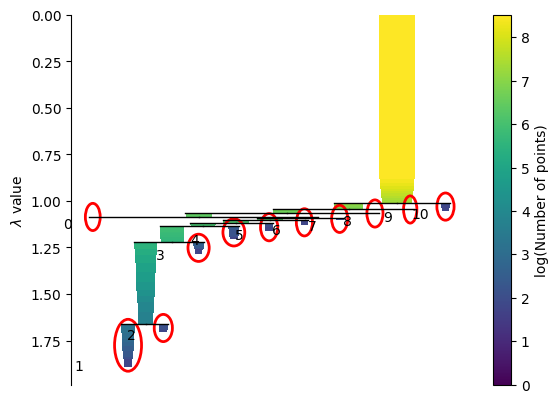

In [29]:
clusterer = run_hdbscan(X, y,
                        min_samples=7,
                        min_cluster_size=5,
                        )

In [30]:
linkage_matrix = get_linkage_matrix_from_hdbscan(clusterer)
segments = get_dendrogram_segments(linkage_matrix[:, [0,1,3,4]])
plot_dendrogram_plotly(segments).show()

for S_min in [2, 3, 4, 5]:
    print(f"\n--- ストラー数 S_min = {S_min} でフィルタリング ---")
    filtered_linkage_matrix = filter_linkage_matrix_by_strahler(linkage_matrix, S_min=S_min, N_leaves=len(_get_leaves(clusterer.condensed_tree_._raw_tree)))
    segments_filtered = get_dendrogram_segments(filtered_linkage_matrix[:, [0,1,3,4]])
    plot_dendrogram_plotly(segments_filtered).show()

len of sorted condensed tree: 20
len of linkage matrix: 10
20
Number of leaves: 11
Leaf ID Map Size: 11
current id: 11
Total Node ID Map Size: 21
current_id: 21
Max Lambda: 1.6592652626014657



--- ストラー数 S_min = 2 でフィルタリング ---
20

--- ストラー数の分布 ---
ストラー数 2: 10 本の枝

--- フィルタリング結果 ---
元のZ行列の行数: 10
ストラー数 >= 2 の行数: 10
root: 20.0
Visiting Node: 20.0
Children of Node 20.0: Child1 [19.], Child2 [10.]
Visiting Node: 19.0
Children of Node 19.0: Child1 [18.], Child2 [9.]
Visiting Node: 18.0
Children of Node 18.0: Child1 [17.], Child2 [8.]
Visiting Node: 17.0
Children of Node 17.0: Child1 [0.], Child2 [16.]
Visiting Node: 0.0
Children of Node 0.0: Child1 [], Child2 []
Visiting Node: 16.0
Children of Node 16.0: Child1 [15.], Child2 [7.]
Visiting Node: 15.0
Children of Node 15.0: Child1 [14.], Child2 [6.]
Visiting Node: 14.0
Children of Node 14.0: Child1 [13.], Child2 [5.]
Visiting Node: 13.0
Children of Node 13.0: Child1 [12.], Child2 [4.]
Visiting Node: 12.0
Children of Node 12.0: Child1 [11.], Child2 [3.]
Visiting Node: 11.0
Children of Node 11.0: Child1 [1.], Child2 [2.]
Visiting Node: 1.0
Children of Node 1.0: Child1 [], Child2 []
Visiting Node: 2.0
Children of Node 2.0: Child1 [], C


--- ストラー数 S_min = 3 でフィルタリング ---
20

--- ストラー数の分布 ---
ストラー数 2: 10 本の枝

--- フィルタリング結果 ---
元のZ行列の行数: 10
ストラー数 >= 3 の行数: 0


ValueError: zero-size array to reduction operation maximum which has no identity

### 

In [ ]:
file_path = "../18_rapids/result/20251021_192858/cuml_hdbscan_condensed_tree_plot.png"
